# WMT of $S_\Omega(\theta)$ and $\frac{d}{dt}M_\Omega(\theta)$
> where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space

> surface terms come from ERA5 and `dMdt` term comes from ORAS5

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filepath=None):
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/{filepath}surf_ds.zarr'))
    return ds

In [3]:
precip = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/precip-2018_2023.zarr'))
pot_temp = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/pt_gulf.zarr'))
u = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/u_ds.zarr'))
v = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/u_ds.zarr'))

In [4]:
#add the last 3 months to each ds
ds2018 = xr.concat([open_ds('2018_'), open_ds('2018_winter_')], dim='time')
ds2019 = xr.concat([open_ds('2019_'), open_ds('2019_winter_')], dim='time')
ds2020 = xr.concat([open_ds('2020_'), open_ds('2020_winter_')], dim='time')
ds2021 = xr.concat([open_ds('2021_'), open_ds('2021_winter_')], dim='time')
ds2022 = xr.concat([open_ds('2022_'), open_ds('2022_winter_')], dim='time')
ds2023 = open_ds('')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [5]:
sst_c = xr.concat([ds2023.sst.isel(expver=0).sel(time=slice(None, '2023-06')),
                   ds2023.sst.isel(expver=1).sel(time=slice('2023-07', None))], dim='time')
runoff_c = xr.concat([ds2023.ro.isel(expver=0).sel(time=slice(None, '2023-07-27')),
                   ds2023.ro.isel(expver=1).sel(time=slice('2023-07-28', None))], dim='time')
rest_c = xr.concat([ds2023.drop(['ro', 'sst']).isel(expver=0).sel(time=slice(None, '2023-08-01')),
                   ds2023.drop(['ro', 'sst']).isel(expver=1).sel(time=slice('2023-08-02', None))], dim='time')

In [6]:
ds2023_c = xr.merge([sst_c.drop('expver'), runoff_c.drop('expver'), 
                     rest_c.drop('expver'), precip.sel(time='2023')])

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1449: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(

In [7]:
ds2023_c

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 7578)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-11-12T17:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(7578, 361, 6), meta=np.ndarray>
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [8]:
ds_unsorted = xr.concat([ds2018, ds2019, ds2020, ds2021, ds2022, ds2023_c], dim='time')
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = ds_unsorted.sortby(ds_unsorted.latitude)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [9]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 51402)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-11-12T17:00:00
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(51402, 361, 6), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

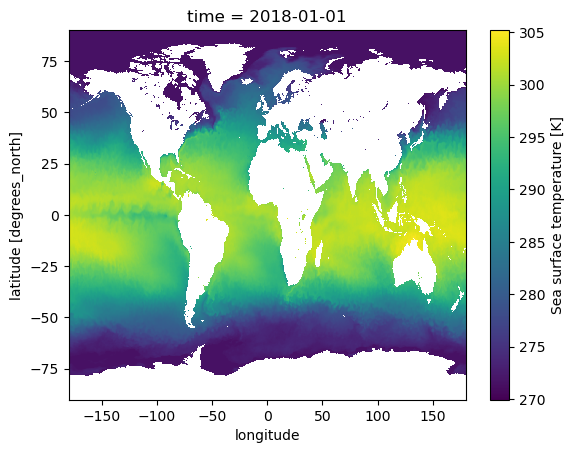

In [16]:
ds.sst[0].plot()

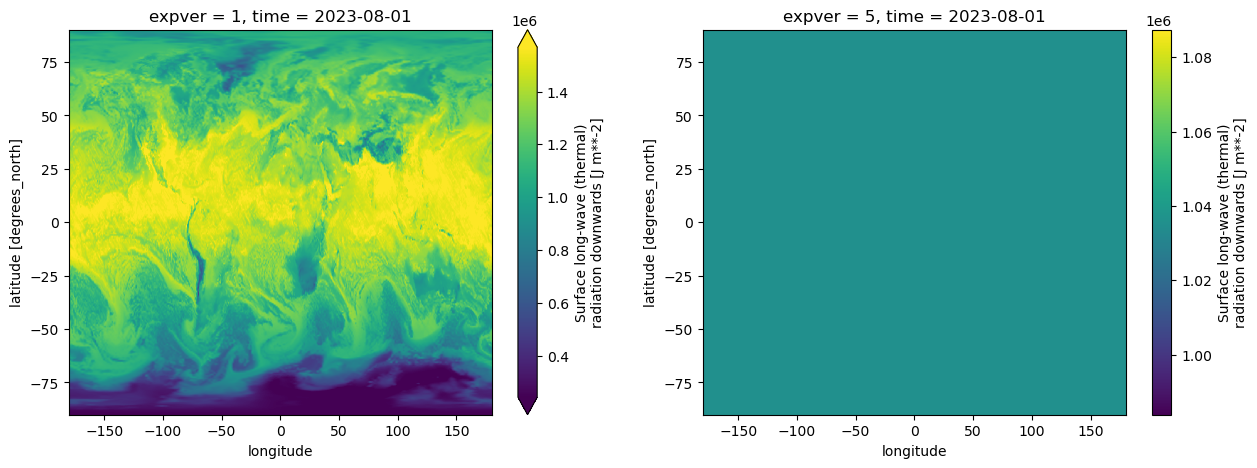

In [155]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ds2023.strd.sel(time='2023-08-01', method='nearest').isel(expver=0).plot(ax=ax0, robust=True)
ds2023.strd.sel(time='2023-08-01', method='nearest').isel(expver=1).plot(ax=ax1, robust=True)

In [156]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ds2023.strd.sel(time='2023-08-02', method='nearest').isel(expver=0).plot(ax=ax0, robust=True)
ds2023.strd.sel(time='2023-08-02', method='nearest').isel(expver=1).plot(ax=ax1, robust=True)

## Create grid and area objects

In [10]:
ds_full = generate_grid_ds(ds, {'X':'longitude', 'Y':'latitude'})

In [11]:
ds_full

<xarray.Dataset>
Dimensions:         (latitude: 721, longitude: 1440, time: 51402,
                     longitude_left: 1440, latitude_left: 721)
Coordinates:
  * latitude        (latitude) float32 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude       (longitude) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
  * time            (time) datetime64[ns] 2018-01-01 ... 2023-11-12T17:00:00
  * longitude_left  (longitude_left) float32 -180.1 -179.9 ... 179.4 179.6
  * latitude_left   (latitude_left) float32 -90.12 -89.88 -89.62 ... 89.62 89.88
Data variables:
    e               (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ro              (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssrd            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssro            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str             (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    strd            (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    tp              (time, latitude, longitude) float32 dask.array<chunksize=(51402, 361, 6), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 19:47:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [12]:
grid = xgcm.Grid(ds_full, periodic=['X'])
#grid_vels = xgcm.Grid(ds_vel, periodic=['X'])

In [13]:
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center

In [14]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [15]:
cell_elements_surf = deg_2_m(grid, ds_full, 'latitude', 'longitude')

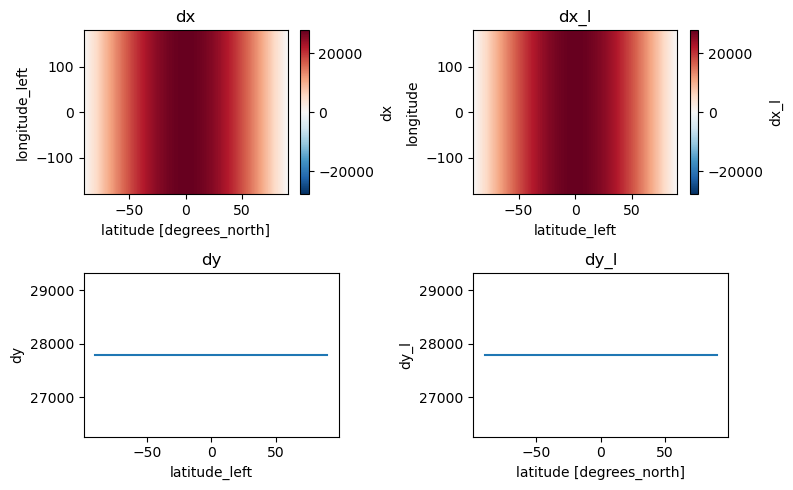

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_surf.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_surf.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_surf.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_surf.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [17]:
gulf = dict(longitude=slice(-100, -72), latitude=slice(22, 31),
            longitude_left=slice(-100, -72), latitude_left=slice(22, 31))

In [18]:
ds_trop = ds_full.sel(**gulf)
cells_trop = cell_elements_surf.sel(**gulf)

In [19]:
cell_elements_surf

<xarray.Dataset>
Dimensions:         (longitude_left: 1440, latitude: 721, longitude: 1440,
                     latitude_left: 721)
Coordinates:
  * longitude_left  (longitude_left) float32 -180.1 -179.9 ... 179.4 179.6
  * latitude        (latitude) float32 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude       (longitude) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude_left   (latitude_left) float32 -90.12 -89.88 -89.62 ... 89.62 89.88
Data variables:
    dx              (longitude_left, latitude) float32 1.749 ... -0.001215
    dx_l            (longitude, latitude_left) float32 -60.65 ... -8.727e+04
    dy              (latitude_left) float32 nan 2.78e+04 ... 2.78e+04 2.78e+04
    dy_l            (latitude) float32 2.78e+04 2.78e+04 ... 2.78e+04 nan

In [20]:
cells_trop

<xarray.Dataset>
Dimensions:         (longitude_left: 112, latitude: 37, longitude: 113,
                     latitude_left: 36)
Coordinates:
  * longitude_left  (longitude_left) float32 -99.88 -99.62 ... -72.38 -72.12
  * latitude        (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude       (longitude) float32 -100.0 -99.75 -99.5 ... -72.25 -72.0
  * latitude_left   (latitude_left) float32 22.12 22.38 22.62 ... 30.62 30.88
Data variables:
    dx              (longitude_left, latitude) float32 2.577e+04 ... 2.383e+04
    dx_l            (longitude, latitude_left) float32 2.575e+04 ... 2.386e+04
    dy              (latitude_left) float32 2.78e+04 2.78e+04 ... 2.78e+04
    dy_l            (latitude) float32 2.78e+04 2.78e+04 ... 2.78e+04 2.78e+04

In [28]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cells_trop.dx.plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cells_trop.dx_l.plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cells_trop.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cells_trop.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [29]:
ds_trop.ro[0].plot(robust=True, cmap=cmocean.cm.thermal)

In [21]:
mask_trop = ds_trop.sst[0].isnull()

/tmp/ipykernel_374/1802560077.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


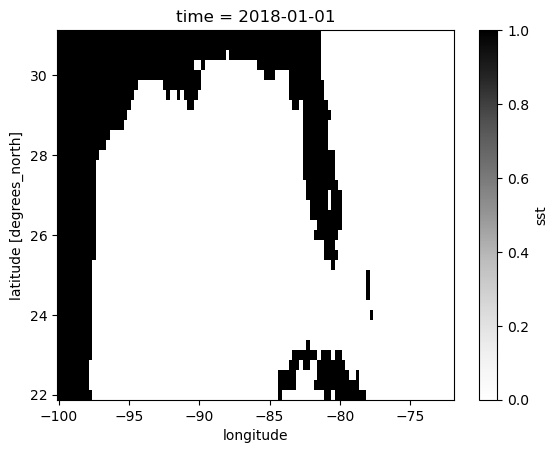

In [22]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_trop.plot(cmap=cmap)

/tmp/ipykernel_430/1430084769.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


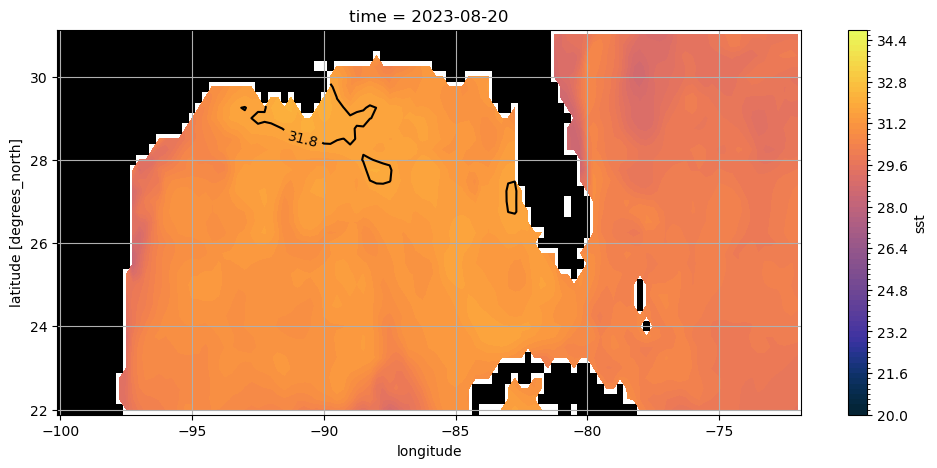

In [32]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_trop.plot(cmap=cmap, add_colorbar=False)

(ds_trop.sst-273.15).sel(time='2023-08-20', method='nearest').plot.contourf(levels=np.arange(20, 35, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = (ds_trop.sst-273.15).sel(time='2023-08-20', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid();

### Calculate surface area of 31.8˚C contour

In [23]:
sst_2023 = (ds_trop.sst - 273.15).sel(time=slice('2023-01-01', '2023-09-28'))
sst_2023

<xarray.DataArray 'sst' (time: 6504, latitude: 37, longitude: 113)>
dask.array<getitem, shape=(6504, 37, 113), dtype=float32, chunksize=(24, 37, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-09-28T23:00:00

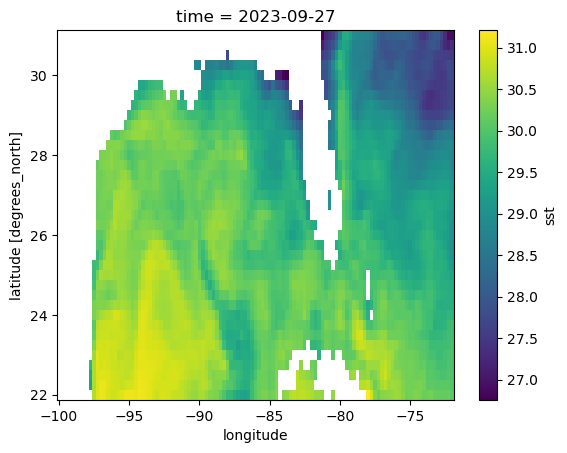

In [27]:
sst_2023.sel(time='2023-09-27T00:00:00.000000000').plot()

In [24]:
sst_resampled = sst_2023.resample(time='D').mean()

In [28]:
wwm = sst_resampled.where(sst_resampled>=31.8)

In [29]:
wwm

<xarray.DataArray 'sst' (time: 271, latitude: 37, longitude: 113)>
dask.array<where, shape=(271, 37, 113), dtype=float32, chunksize=(1, 37, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-09-28

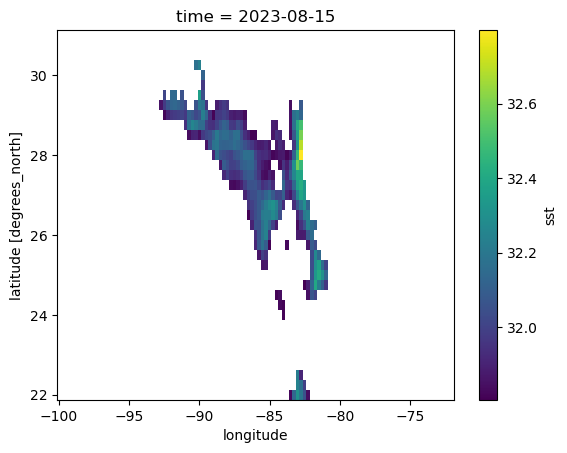

In [30]:
wwm.sel(time='2023-08-15').plot()

In [31]:
wwm_area_weighted = wwm * area

NameError: name 'area' is not defined

In [32]:
wwm_area_weighted

NameError: name 'wwm_area_weighted' is not defined

In [54]:
tot_area_2023 = wwm_area_weighted.sum(['latitude', 'longitude', 'time'])

In [55]:
tot_area_2023.compute()

<xarray.DataArray ()>
array(1.5866802e+14, dtype=float32)

In [113]:
f'{(3.355318e+14 - 1.5866802e+14):.14}'

'1.7686378e+14'

In [171]:
wwm_area_weighted.sum(['latitude', 'longitude']).argmax().values

array(224)

In [175]:
wwm_area_weighted[224].sum(['latitude', 'longitude']).values

array(1.162951e+12, dtype=float32)

# Budget

In [33]:
np.diff(ds_trop.time)/1e9

array([3600, 3600, 3600, ..., 3600, 3600, 3600], dtype='timedelta64[ns]')

In [34]:
ds_trop.time

<xarray.DataArray 'time' (time: 51402)>
array(['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
       '2018-01-01T02:00:00.000000000', ..., '2023-11-12T15:00:00.000000000',
       '2023-11-12T16:00:00.000000000', '2023-11-12T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2023-11-12T17:00:00
Attributes:
    long_name:  time

In [25]:
ds_trop_new = ds_trop #/ 3600 #divide by total sec in an hr to get time dim

In [26]:
#too lazy to rename, after running next cell then the units will be as written (i.e. '/s')
sw = ds_trop_new.ssr #J/m^2 s
lw = ds_trop_new.str #J/m^2 s
sensible = ds_trop_new.sshf #J/m^2 s
latent = ds_trop_new.slhf #J/m^2 s
evap = ds_trop_new.e #m/s
runoff = ds_trop_new.ro #m/s
#precip = #m/s

In [27]:
#short-longwave; sensible latent
slsl = xr.merge([sw, lw, sensible, latent])
#e-p-r 
epr = xr.merge([evap, runoff])#, precip])
#resample to daily
slsl_resampled = slsl.resample(time='D').mean() /(60*60*24) #divide by total sec in a day to get time dim
epr_resampled = epr.resample(time='D').mean() / (60*60*24)

In [28]:
theta_resampled = (ds_trop.sst - 273.15).resample(time='D').mean()
#theta_resampled_sec = (ds_trop_new.sst - 273.15).resample(time='D').mean()

In [29]:
theta_resampled

<xarray.DataArray 'sst' (time: 2142, latitude: 37, longitude: 113)>
dask.array<transpose, shape=(2142, 37, 113), dtype=float32, chunksize=(46, 37, 113), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12

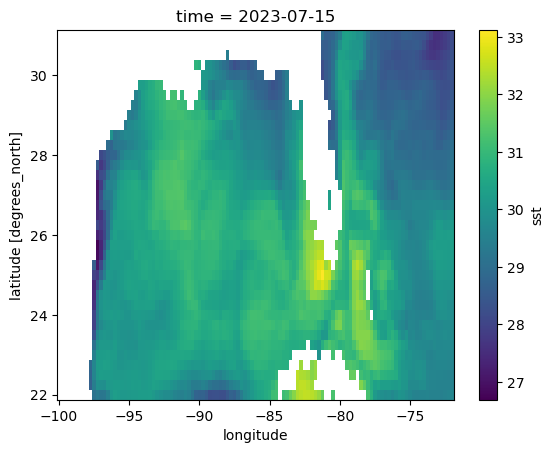

In [40]:
theta_resampled.sel(time='2023-07-15', method='nearest').plot()

In [40]:
slsl_resampled

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 113, time: 2142)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12
Data variables:
    ssr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    str        (time, latitude, longitude) float64 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 dask.array<chunksize=(1, 37, 113), meta=np.ndarray>
Attributes:
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux
    units:          J m**-2

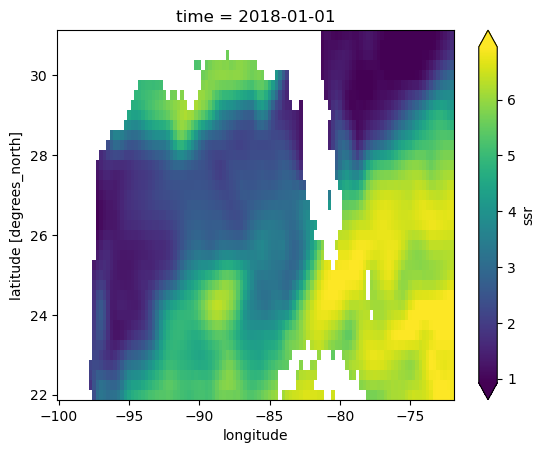

In [41]:
slsl_resampled.ssr[0].where(~mask_trop).plot(robust=True)

In [30]:
grid_trop = xgcm.Grid(ds_trop, periodic=['X'])

In [31]:
dx_interp = grid_trop.interp(cells_trop.dx_l, 'Y')
area = dx_interp * cells_trop.dy_l

In [32]:
area

<xarray.DataArray (longitude: 113, latitude: 37)>
array([[6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08],
       [6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08],
       [6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08],
       ...,
       [6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08],
       [6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08],
       [6.8956288e+08, 7.1522784e+08, 7.1394426e+08, ..., 6.6583917e+08,
        6.6412147e+08, 6.8956288e+08]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0

In [46]:
theta_resampled.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12

In [47]:
theta_resampled.time

<xarray.DataArray 'time' (time: 2142)>
array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', ..., '2023-11-10T00:00:00.000000000',
       '2023-11-11T00:00:00.000000000', '2023-11-12T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12

In [33]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1034 #kg/m^3
#alpha = 3e-4 #1/˚C from DOI:10.1126/sciadv.abq0793

#var (J/m^2 s) x 1/Cp x area x alpha
slsl_weighted = slsl_resampled * area * (1/Cp) * (1/rho) #˚C m^3/s

#var (m/s) x area x rho
epr_weighted = epr_resampled * area * theta_resampled #C m^3/s

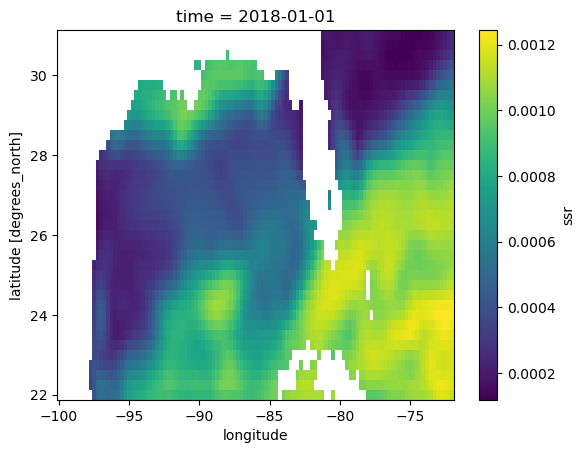

In [49]:
(slsl_weighted.ssr[0].where(~mask_trop)/1e6).plot()

In [50]:
slsl_weighted.chunk({'time':535, 'latitude':-1, 'longitude':-1})

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 113, time: 2142)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12
Data variables:
    ssr        (time, latitude, longitude) float64 dask.array<chunksize=(535, 37, 113), meta=np.ndarray>
    str        (time, latitude, longitude) float64 dask.array<chunksize=(535, 37, 113), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 dask.array<chunksize=(535, 37, 113), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 dask.array<chunksize=(535, 37, 113), meta=np.ndarray>

In [34]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)

def hist_func(ds, variable):
    hist = histogram(theta_resampled.where(~mask_trop).rename('theta'), bins=[theta_bins],
                    weights=(ds[variable].where(~mask_trop)).fillna(0.),
                    dim=['longitude', 'latitude']) / delta_theta
    return hist #m^3/s (Sv)

In [35]:
#rename vars with `omega_` as prefix to highlight new hist ds
slsl_hist = xr.merge([hist_func(slsl_weighted.chunk({'time':535, 'latitude':-1, 'longitude':-1}), var).rename('omega_' + var) 
                      for var in list(slsl_weighted)])
epr_hist =xr.merge([hist_func(epr_weighted.chunk({'time':535, 'latitude':-1, 'longitude':-1}), var).rename('omega_' + var) 
                    for var in list(epr_weighted)])

In [36]:
slsl_hist

<xarray.Dataset>
Dimensions:     (time: 2142, theta_bin: 139)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12
  * theta_bin   (theta_bin) float64 20.05 20.15 20.25 ... 33.65 33.75 33.85
Data variables:
    omega_ssr   (time, theta_bin) float64 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_str   (time, theta_bin) float64 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float64 dask.array<chunksize=(1, 139), meta=np.ndarray>
    omega_slhf  (time, theta_bin) float64 dask.array<chunksize=(1, 139), meta=np.ndarray>

- sw = ssr 
- lw = str 
- sensible = sshf 
- latent = slhf 
- evap = e 
- runoff = ro 

In [37]:
(slsl_hist/1e6).sel(theta_bin=31.8, method='nearest').sel(time=slice('2023-01', 
                                                               None)).chunk({'time':-1})

<xarray.Dataset>
Dimensions:     (time: 316)
Coordinates:
  * time        (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-12
    theta_bin   float64 31.75
Data variables:
    omega_ssr   (time) float64 dask.array<chunksize=(316,), meta=np.ndarray>
    omega_str   (time) float64 dask.array<chunksize=(316,), meta=np.ndarray>
    omega_sshf  (time) float64 dask.array<chunksize=(316,), meta=np.ndarray>
    omega_slhf  (time) float64 dask.array<chunksize=(316,), meta=np.ndarray>

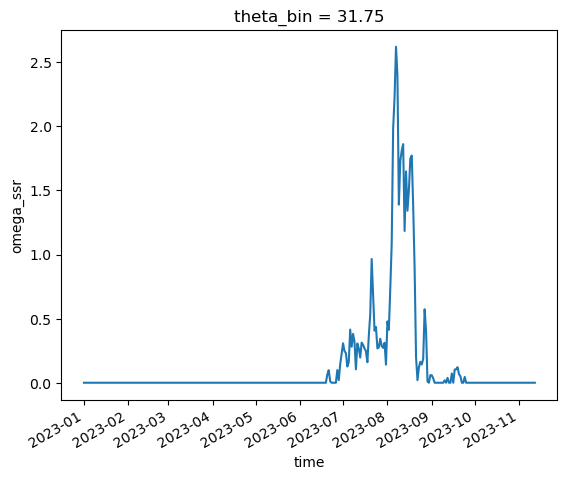

In [38]:
(slsl_hist.omega_ssr/1e6).sel(theta_bin=31.8, method='nearest').sel(time=slice('2023-01', 
                                                               None)).chunk({'time':-1}).plot()

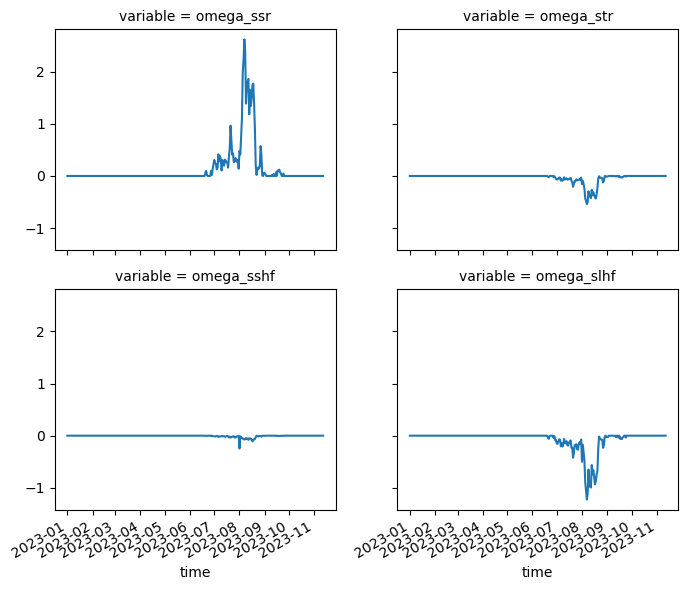

In [286]:
(slsl_hist/1e6).sel(theta_bin=31.8, method='nearest').sel(time=slice('2023-01', 
                                                               None)).chunk({'time':-1}).to_array().plot(col='variable', 
                                                                                                         col_wrap=2)

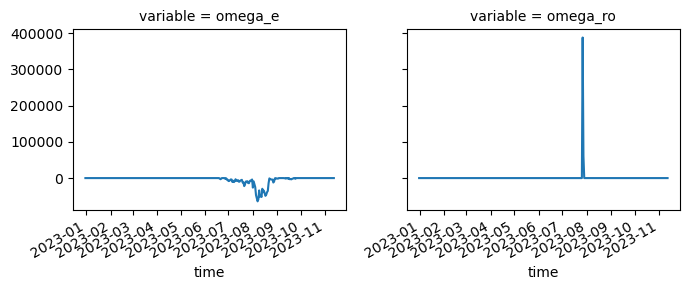

In [287]:
epr_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', 
                                                               None)).chunk({'time':-1}).to_array().plot(col='variable')

In [50]:
one_plt = slsl_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', None))
epr_one_plt = epr_hist.sel(theta_bin=31.8, method='nearest').sel(time=slice('2022-12-31', None))

- sw = ssr 
- lw = str 
- sensible = sshf 
- latent = slhf 
- evap = e 
- runoff = ro 

In [165]:
one_plt

<xarray.Dataset>
Dimensions:     (time: 317)
Coordinates:
  * time        (time) datetime64[ns] 2022-12-31 2023-01-01 ... 2023-11-12
    theta_bin   float64 31.75
Data variables:
    omega_ssr   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    omega_str   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    omega_sshf  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    omega_slhf  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

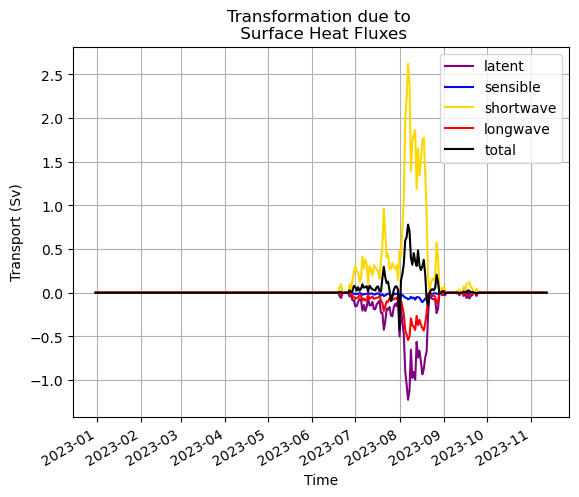

In [55]:
(one_plt.omega_slhf/1e6).plot(label='latent', color='purple')
(one_plt.omega_sshf/1e6).plot(label='sensible', color='blue')
(one_plt.omega_ssr/1e6).plot(label='shortwave', color='gold')
(one_plt.omega_str/1e6).plot(label='longwave', color='r')
(one_plt/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.grid()
plt.legend()
plt.title('Transformation due to \n Surface Heat Fluxes')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time');

### Save histograms

In [39]:
merged_hist = xr.merge([slsl_hist, epr_hist])

In [40]:
2142/4

535.5

In [41]:
merged_hist.chunk({'theta_bin':-1, 'time':535})

<xarray.Dataset>
Dimensions:     (time: 2142, theta_bin: 139)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-11-12
  * theta_bin   (theta_bin) float64 20.05 20.15 20.25 ... 33.65 33.75 33.85
Data variables:
    omega_ssr   (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>
    omega_str   (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>
    omega_slhf  (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>
    omega_e     (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>
    omega_ro    (time, theta_bin) float64 dask.array<chunksize=(535, 139), meta=np.ndarray>

In [42]:
#uploading histograms
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/hist_ds.zarr')
merged_hist.chunk({'theta_bin':-1, 'time':535}).to_zarr(gcsmap_ds, mode='w')

## dMdt - ORAS5

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

pot_temp = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/pt_gulf.zarr'))
pot_temp_full = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/ERA5/datasets/pot-temp75z.zarr')) #for grid obj
#u = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/u_ds.zarr'))
#v = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/u_ds.zarr'))

In [9]:
pot_temp_full

<xarray.Dataset>
Dimensions:            (deptht: 75, y: 1021, x: 1442, time_counter: 10, bnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 2023-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
    votemper           (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 5.1.1 (Homepage = http://nco.sf.ne...
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...
    source:       ORAS5 - backward extension (ECMWF)
    title:        Monthly mean temperature

In [7]:
pot_temp

<xarray.Dataset>
Dimensions:       (deptht: 75, y: 44, x: 113, time_counter: 10)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2023-01-16T12:00:00 ... 2023-...
Dimensions without coordinates: y, x
Data variables:
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 44, 113), meta=np.ndarray>

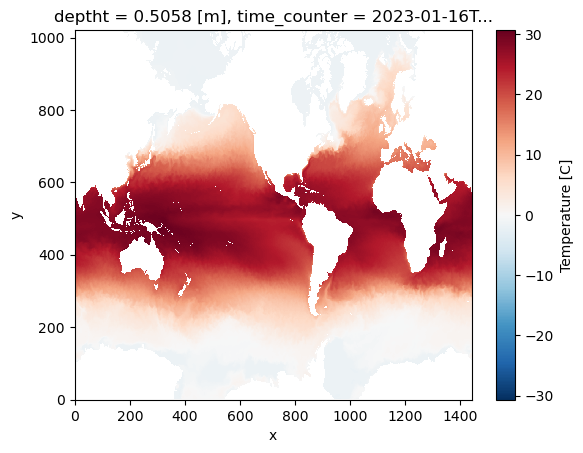

In [51]:
pot_temp_full.votemper[0,0].plot()

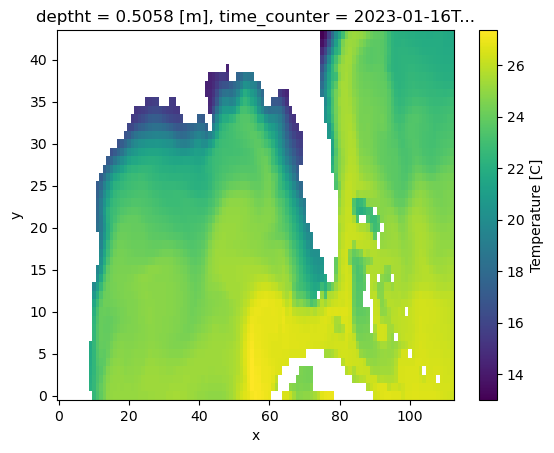

In [52]:
pot_temp.votemper[0,0].plot()

### Create grid and area objects

In [9]:
pot_temp.nav_lat.shape

(44, 113)

In [10]:
pot_temp.nav_lon.shape

(44, 113)

In [11]:
pot_temp.nav_lon[:, -1].values

array([-72.00001 , -72.00001 , -72.000015, -72.00003 , -72.00004 ,
       -72.00006 , -72.00008 , -72.00011 , -72.00014 , -72.00018 ,
       -72.00023 , -72.00028 , -72.00035 , -72.00043 , -72.00052 ,
       -72.000626, -72.00074 , -72.00087 , -72.00102 , -72.00119 ,
       -72.00138 , -72.00159 , -72.001816, -72.002075, -72.00236 ,
       -72.00266 , -72.003   , -72.00337 , -72.00377 , -72.0042  ,
       -72.00468 , -72.00518 , -72.00573 , -72.00632 , -72.00695 ,
       -72.00763 , -72.008354, -72.00913 , -72.00996 , -72.01084 ,
       -72.01177 , -72.01277 , -72.013824, -72.014946], dtype=float32)

In [5]:
#ds_pt = generate_grid_ds(pot_temp, {'X': 'x', 'Y':'y'})
ds_pt_full = generate_grid_ds(pot_temp_full, {'X': 'x', 'Y':'y'})

In [6]:
ds_pt_full

<xarray.Dataset>
Dimensions:         (depth: 50, latitude: 109, longitude: 337, time: 304,
                     longitude_left: 337, latitude_left: 109)
Coordinates:
  * depth           (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude        (latitude) float32 22.0 22.08 22.17 ... 30.83 30.92 31.0
  * longitude       (longitude) float32 -100.0 -99.92 -99.83 ... -72.08 -72.0
  * time            (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T...
  * longitude_left  (longitude_left) float32 -100.0 -99.96 ... -72.12 -72.04
  * latitude_left   (latitude_left) float32 21.96 22.04 22.13 ... 30.88 30.96
Data variables:
    thetao          (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.8
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    area:              Global
    comment:           
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    ...                ...
    institution:       Mercator Ocean International
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    title:             daily mean fields from Global Ocean Physics Analysis a...

In [21]:
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'], boundary="fill", fill_value=0.)
#grid_pt = xgcm.Grid(ds_pt, periodic=['X'])

In [22]:
grid_pt_full

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   depth
T Axis (not periodic, boundary='fill'):
  * center   time
Y Axis (periodic, boundary='fill'):
  * center   latitude --> left
  * left     latitude_left --> center
X Axis (periodic, boundary='fill'):
  * center   longitude --> left
  * left     longitude_left --> center

In [131]:
ds_pt_full.y

<xarray.DataArray 'y' (y: 1021)>
array([   0,    1,    2, ..., 1018, 1019, 1020])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1014 1015 1016 1017 1018 1019 1020
Attributes:
    axis:     Y

In [132]:
ds_pt_full.y_left

<xarray.DataArray 'y_left' (y_left: 1021)>
array([-5.0000e-01,  5.0000e-01,  1.5000e+00, ...,  1.0175e+03,  1.0185e+03,
        1.0195e+03])
Coordinates:
  * y_left   (y_left) float64 -0.5 0.5 1.5 2.5 ... 1.018e+03 1.018e+03 1.02e+03
Attributes:
    axis:               Y
    c_grid_axis_shift:  -0.5

In [21]:
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'], boundary="fill", fill_value=0.)
#grid_pt = xgcm.Grid(ds_pt, periodic=['X'])

In [22]:
grid_pt_full

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   depth
T Axis (not periodic, boundary='fill'):
  * center   time
Y Axis (periodic, boundary='fill'):
  * center   latitude --> left
  * left     latitude_left --> center
X Axis (periodic, boundary='fill'):
  * center   longitude --> left
  * left     longitude_left --> center

In [9]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [128]:
t = grid_pt_full.diff(pot_temp_full.nav_lat.astype('f4'), 'Y', boundary='fill', fill_value=np.nan) * meters_per_degree

In [134]:
t = grid_pt_full.diff(pot_temp_full.nav_lon.astype('f4'), 'X', boundary='fill', fill_value=np.nan) * meters_per_degree

In [135]:
t

<xarray.DataArray 'nav_lon' (y: 1021, x_left: 1442)>
dask.array<mul, shape=(1021, 1442), dtype=float32, chunksize=(1021, 1442), chunktype=numpy.ndarray>
Coordinates:
  * x_left   (x_left) float64 -0.5 0.5 1.5 2.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1014 1015 1016 1017 1018 1019 1020

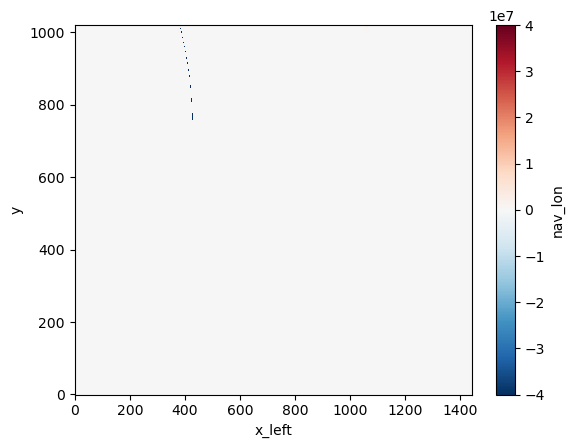

In [136]:
t1021.plot()

In [60]:
grid_pt_full.diff(ds_pt_full.y, 'Y', boundary='fill', fill_value=999)

<xarray.DataArray 'y' (y_left: 1021)>
array([-999,    1,    1, ...,    1,    1,    1])
Coordinates:
  * y_left   (y_left) float64 -0.5 0.5 1.5 2.5 ... 1.018e+03 1.018e+03 1.02e+03

In [61]:
grid_pt_full.diff(ds_pt_full.x, 'X')

<xarray.DataArray 'x' (x_left: 1442)>
array([-1441,     1,     1, ...,     1,     1,     1])
Coordinates:
  * x_left   (x_left) float64 -0.5 0.5 1.5 2.5 ... 1.438e+03 1.44e+03 1.44e+03

In [62]:
tx = grid_pt_full.diff(ds_pt_full.nav_lon, 'X')

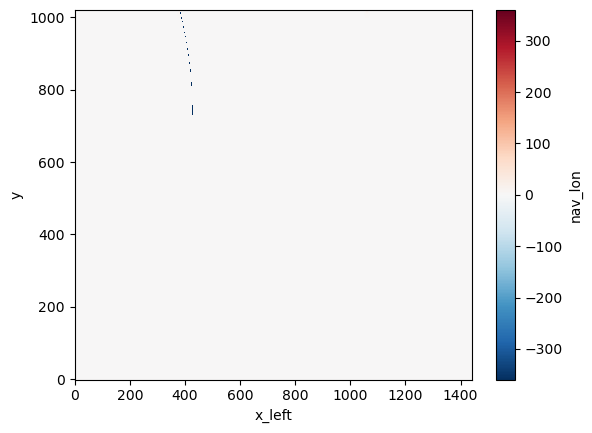

In [63]:
tx[:-1, 1:-1].plot()

In [67]:
pot_temp_full['x']

<xarray.DataArray 'x' (x: 1442)>
array([   0,    1,    2, ..., 1439, 1440, 1441])
Dimensions without coordinates: x

In [10]:
cell_elements_pt_full= deg_2_m(grid_pt_full, ds_pt_full, 'y', 'x')

In [11]:
cell_elements_pt_full

<xarray.Dataset>
Dimensions:         (longitude_left: 337, latitude: 109, longitude: 337,
                     latitude_left: 109)
Coordinates:
  * longitude_left  (longitude_left) float32 -100.0 -99.96 ... -72.12 -72.04
  * latitude        (latitude) float32 22.0 22.08 22.17 ... 30.83 30.92 31.0
  * longitude       (longitude) float32 -100.0 -99.92 -99.83 ... -72.08 -72.0
  * latitude_left   (latitude_left) float32 21.96 22.04 22.13 ... 30.88 30.96
Data variables:
    dx              (longitude_left, latitude) float32 -2.887e+06 ... 7.942e+03
    dx_l            (longitude, latitude_left) float32 8.595e+03 ... -2.67e+06
    dy              (latitude_left) float32 nan 9.267e+03 ... 9.266e+03
    dy_l            (latitude) float32 9.267e+03 9.267e+03 ... 9.266e+03 nan

In [ ]:
#converting lat from degrees to meters
delta_lat = grid_pt_full.diff(ds_pt_full.nav_lat.astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree
delta_lat_l = grid_pt_full.diff(ds_pt_full.y_left, 'Y', boundary='fill', fill_value=np.nan)
dy_l = delta_lat_l * meters_per_degree

In [ ]:
#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_pt_full.diff(ds_pt_full.x, 'X')#, boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_pt_full.y))
delta_lon_l = grid_pt_full.diff(ds_pt_full.x_left, 'X')#, boundary_discontinuity=360)
dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_pt_full.y_left))

In [96]:
cell_elements = cell_elements_pt_full.isel(y=slice(-433,-389), y_left=slice(-433,-389), 
                           x=slice(749,862), x_left=slice(749,862))

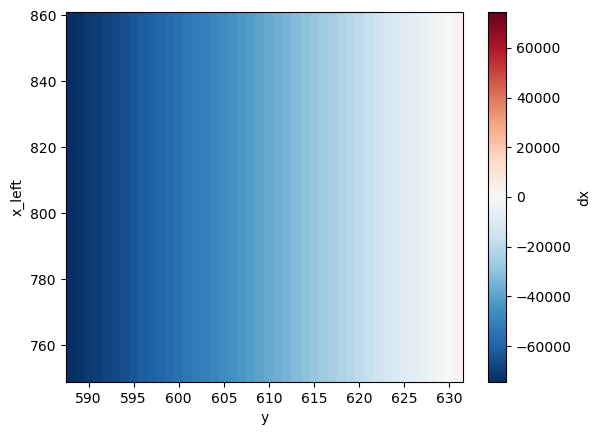

In [97]:
cell_elements.dx[1:].plot()

1) cell_elements = deg_r_m(grid, ds_full, lat, lon)
2) gulf slices
3) ds_gulf, cell_elements_gulf = ds_full.slice, cell_elements.slice
4) grid_gulf = xgcm.Grid(ds_gulf, periodic=['X'])
4a) dx_interp = grid_gulf.interp(cell_elements_gulf.dx_l, 'Y')
5) area = dx_interp * cell_elements_gulf.dy_l

In [13]:
cell_elements = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

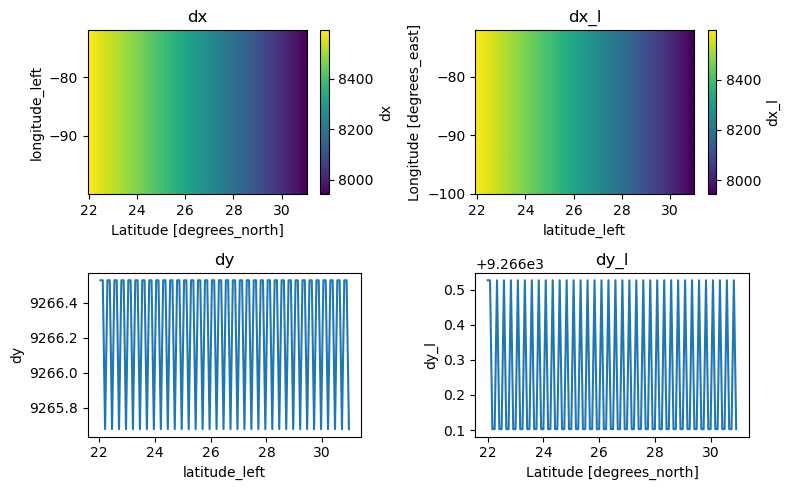

In [52]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

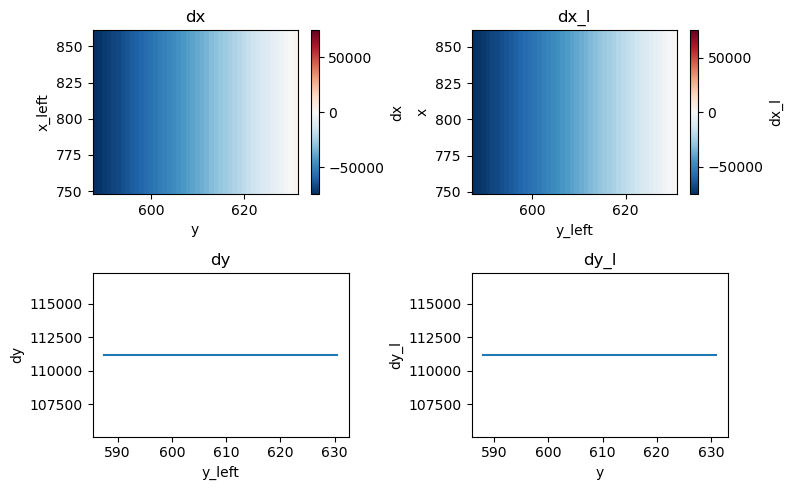

In [99]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements.dx.plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements.dx_l.plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [98]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)

cell_elements.dy.plot(ax=ax[0])
ax[0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1])
ax[1].set_title('dy_l')
plt.ylim(111190, 111200)
plt.tight_layout();

In [58]:
pot_temp_full.nav_lon.plot()

In [22]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_pt.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_pt.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_pt.dy[1:].plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_pt.dy_l[:-1].plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [67]:
(cell_elements_pt.dx[1:] * cell_elements_pt.dy_l[:-1]).plot(robust=True)

In [68]:
(cell_elements_pt.dx[1:, 1:] * cell_elements_pt.dy_l[:-1]).plot(robust=True)

In [69]:
mask_pt = pot_temp.votemper.isel(time_counter=0, deptht=0).isnull()

In [55]:
mask_pt = gopaf_pottemp.thetao.isel(time=0, depth=0).isnull()

In [56]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap)

/tmp/ipykernel_469/3224994717.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


In [64]:
gopaf_pottemp.thetao[180]

<xarray.DataArray 'thetao' (depth: 50, latitude: 109, longitude: 337)>
dask.array<getitem, shape=(50, 109, 337), dtype=float32, chunksize=(50, 109, 337), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
    time       datetime64[ns] 2023-06-30T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

/tmp/ipykernel_469/813423946.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


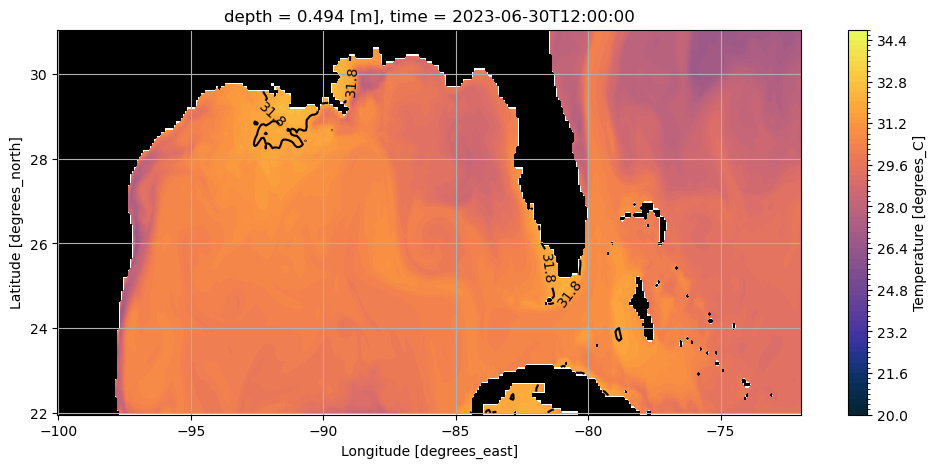

In [65]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap, add_colorbar=False)

gopaf_pottemp.thetao[180,0].plot.contourf(levels=np.arange(20, 35, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = gopaf_pottemp.thetao[180,0].plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid();

### Budget

In [72]:
#60s=1min, 60min=1hr, 24hr=1dy, 30.437dys=1mo on avg
60*60*24*30.437 #s

2629756.8000000003

In [73]:
#units: ˚C/s
pt_new = pot_temp / (60*60*24*30.437) #divide by total sec in a month to get time dim

In [74]:
pt_new

<xarray.Dataset>
Dimensions:       (deptht: 75, y: 44, x: 113, time_counter: 10)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(44, 113), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2023-01-16T12:00:00 ... 2023-...
Dimensions without coordinates: y, x
Data variables:
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 44, 113), meta=np.ndarray>

In [75]:
dx_interp = grid_pt.interp(cell_elements_pt.dx_l, 'Y')

In [76]:
dx_interp[:-1]

<xarray.DataArray 'dx_l' (x: 112, y: 44)>
array([[111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288],
       [111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288],
       [111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288],
       ...,
       [111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288],
       [111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288],
       [111190.69268247, 111173.75780141, 111122.95831676, ...,
         83916.68099907,  82630.78790823,  96586.09603288]])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42 43

In [77]:
cell_elements_pt.dy_l

<xarray.DataArray 'dy_l' (y: 44)>
array([1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.06357947e+08])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42 43

In [78]:
pt_new.votemper[:,:-1,:-1,:-1].shape

(10, 74, 43, 112)

In [80]:
cell_elements_pt.dy_l

<xarray.DataArray 'dy_l' (y: 44)>
array([1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.11194927e+05,
       1.11194927e+05, 1.11194927e+05, 1.11194927e+05, 1.06357947e+08])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42 43

In [129]:
vol.shape

(43, 112, 74)

In [135]:
pot_temp.votemper.shape

(10, 75, 44, 113)

In [ ]:
dMdt = vol * pt_new.votemper

In [96]:
dx_interp = grid_pt_full.interp(cell_elements.dx_l, 'Y')

dz = gopaf_pottemp.depth.diff(dim='depth', label='upper')
vol = cell_elements.dy_l[:-1] * dx_interp[:-1, :-1] * dz
masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :-1, :-1]>=31.8) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

In [97]:
V

<xarray.DataArray (time: 304)>
dask.array<truediv, shape=(304,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

### CHECK DX/DY OBJECT, IT'S SHOWING 1˚ WHEN IT NEEDS TO BE 0.25˚
> How much surface area the blob takes up in both oras5 and era5 to make sure both ds are similar enough for lhs/rhs computation

In [99]:
V.load()

<xarray.DataArray (time: 304)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       4.04216742e+12, 3.58660388e+12, 3.26509370e+12, 2.37990602e+12,
       1.18685395e+12, 5.27484060e+11, 4.21409882e+11, 4.68438647e+11,
       4.15441519e+11, 4.55413334e+11, 5.70229457e+11, 7.00543009e+11,
       6.26641011e+11, 2.64732819e+11, 1.50436381e+11, 1.85961759e+11,
       1.20460616e+11, 4.85082778e+09, 1.75864371e+09, 8.79143296e+08,
       4.39551488e+08, 4.39551488e+08, 8.79143296e+08, 3.05011488e+08,
       5.75126208e+08, 5.56785344e+08, 3.24294989e+09, 1.85140797e+10,
       2.91097764e+10, 4.05178409e+10, 6.20992430e+10, 1.16794335e+11,
       1.42144930e+11, 1.58773543e+11, 1.15309003e+11, 9.41187891e+10,
       9.64800348e+10, 8.92238807e+10, 8.18579866e+10, 5.47006956e+10,
       1.01209764e+10, 1.50215501e+09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

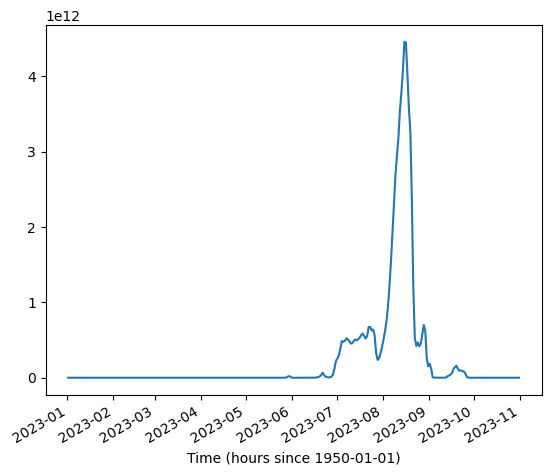

In [100]:
V.plot()

In [101]:
dVdt = V.diff('time', label='upper') / (60*60*24*30.437) #m^3s

In [102]:
dVdt.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
Attributes:
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    valid_max:            640668.0
    valid_min:            639924.0

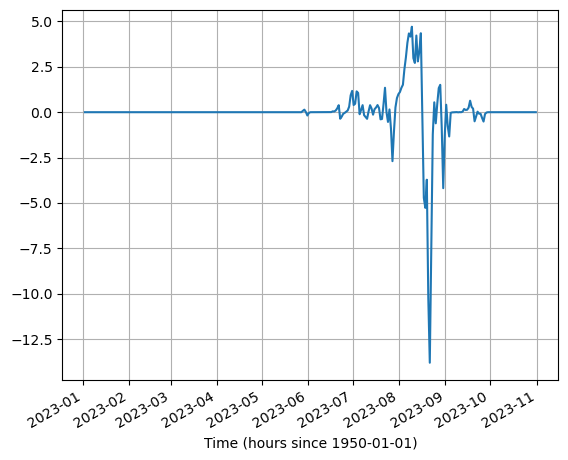

In [109]:
(dVdt/1e6).plot()
plt.grid()

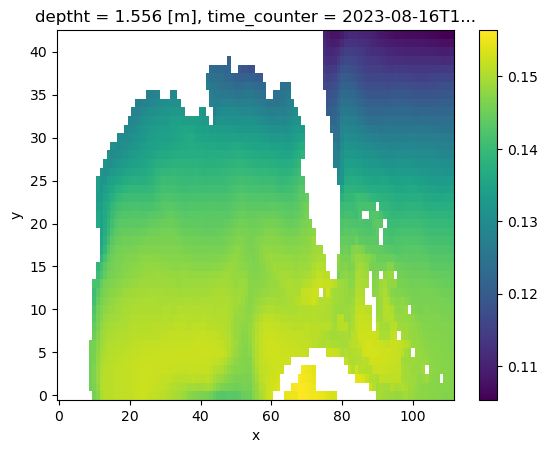

In [83]:
(dMdt[7,0]/1e6).plot()

In [84]:
pot_temp.votemper.shape

(10, 75, 44, 113)

In [85]:
mask_pt.shape

(44, 113)

In [86]:
#compare mask and pot_temp.votemper objs
#lat
print(np.array_equal(mask_pt[:, :].nav_lat, pot_temp.votemper[0,0,:, :].nav_lat))
#lon
(np.array_equal(mask_pt[:, :].nav_lon, pot_temp.votemper[0,0,:, :].nav_lon))

True


True

In [87]:
#why false if nav_lat/nav_lon are equal?
np.array_equal(mask_pt, pot_temp.votemper[0,0])

False

In [88]:
dMdt.shape

(10, 73, 43, 112)

In [89]:
pot_temp.votemper[:,:-1,:-1,:-1].shape

(10, 74, 43, 112)

In [90]:
#compare dMdt and pot_temp.votemper objs
#lon
print(np.array_equal(pot_temp.votemper[0,0,0,:-1].nav_lon, dMdt[0,0,0,:].nav_lon))
#lat
print(np.array_equal(pot_temp.votemper[0,0,:-1,0].nav_lat, dMdt[0,0,:,0].nav_lat))
#deptht
print(np.array_equal(pot_temp.votemper[0,1:-1,0,0].deptht, dMdt[0,:,0,0].deptht))
#time
print(np.array_equal(pot_temp.votemper[:,0,0,0].time_counter, dMdt[:,0,0,0].time_counter))

True
True
True
True


In [91]:
#why false if all dims are equal?
np.array_equal(dMdt, pot_temp.votemper[:, 1:-1, :-1, :-1])

False

In [119]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)

def hist_func(da):
    hist = histogram(pot_temp.votemper[:,1:-1,:-1,:-1].where(~mask_pt[:-1, :-1]).rename('theta'), bins=[theta_bins],
                    weights=(da.where(~mask_pt[:-1, :-1]).fillna(0.)),
                    dim=['x', 'y', 'deptht']) / delta_theta
    return hist #m^3/s (Sv)

In [93]:
#rename vars with `omega_` as prefix to highlight new hist ds
dMdt_hist = hist_func(dMdt).rename('omega_dMdt') 

In [126]:
(dMdt_hist.sel(theta_bin=31.8, method='nearest')/1e6).plot()
plt.title('dMdt')
plt.ylabel('Sv')
plt.xlabel('Months');

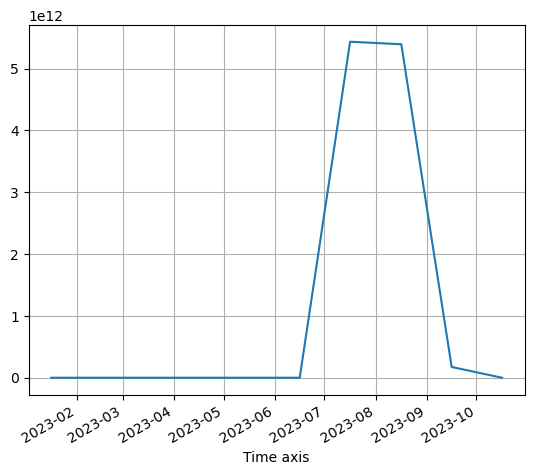

In [179]:
V.plot()
plt.grid()

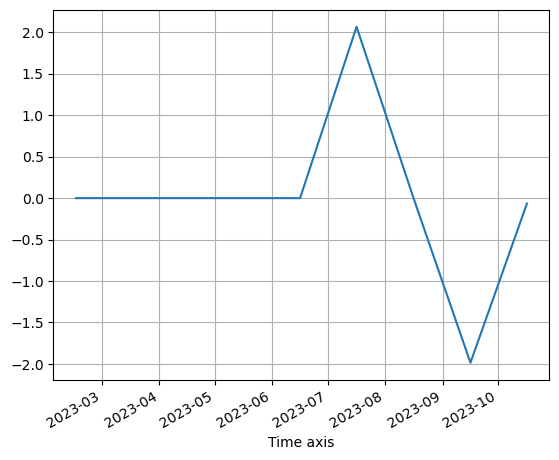

In [173]:
(dVdt/1e6).plot()
plt.grid()

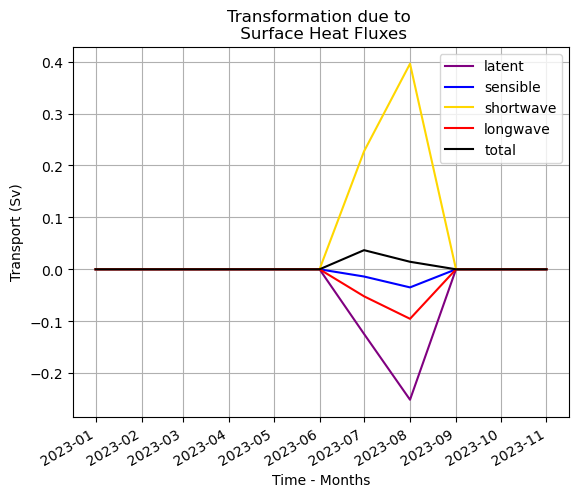

In [49]:
(one_plt.omega_slhf/1e6).plot(label='latent', color='purple')
(one_plt.omega_sshf/1e6).plot(label='sensible', color='blue')
(one_plt.omega_ssr/1e6).plot(label='shortwave', color='gold')
(one_plt.omega_str/1e6).plot(label='longwave', color='r')
(one_plt/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.grid()
plt.legend()
plt.title('Transformation due to \n Surface Heat Fluxes')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time - Months');

## dMdt - GOPAF

In [90]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gopaf_pottemp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr'))

In [91]:
gopaf_pottemp

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 337, time: 304)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.8
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    area:              Global
    comment:           
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    ...                ...
    institution:       Mercator Ocean International
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    title:             daily mean fields from Global Ocean Physics Analysis a...

In [92]:
gopaf_pottemp.time

<xarray.DataArray 'time' (time: 304)>
array(['2023-01-01T12:00:00.000000000', '2023-01-02T12:00:00.000000000',
       '2023-01-03T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
Attributes:
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    valid_max:            640668.0
    valid_min:            639924.0

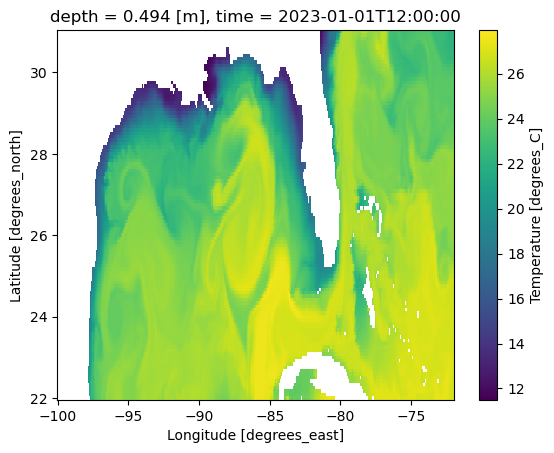

In [13]:
gopaf_pottemp.thetao[0,0].plot()

### Create grid and area objects

In [93]:
ds_pt_full = generate_grid_ds(gopaf_pottemp, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [94]:
grid_pt_full

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   depth
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center

In [95]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [96]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

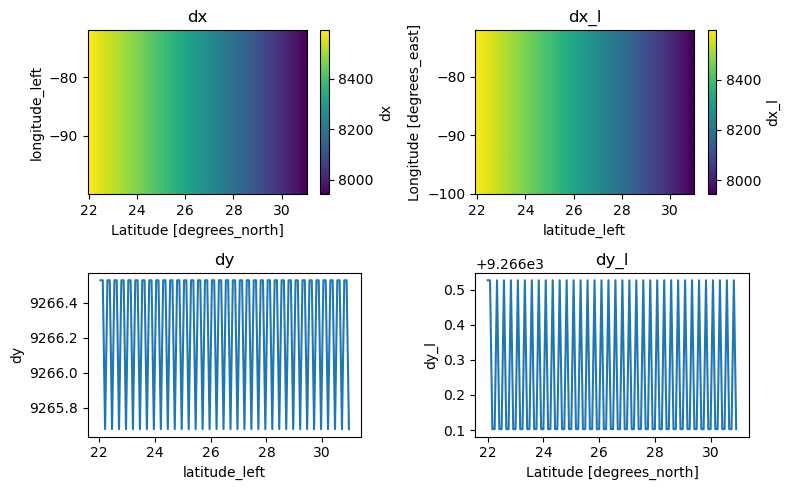

In [97]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [98]:
mask_pt = gopaf_pottemp.thetao.isel(time=0, depth=0).isnull()

/tmp/ipykernel_1582/3224994717.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


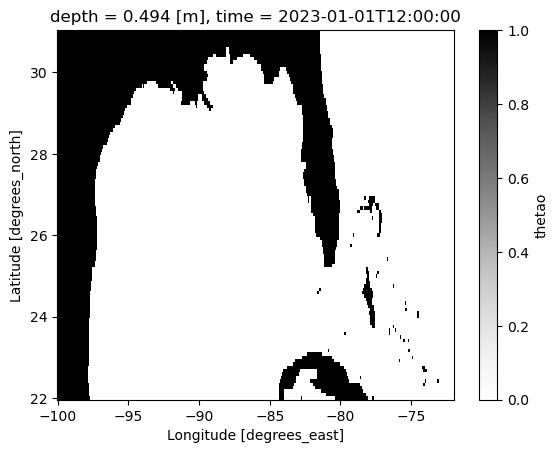

In [99]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap)

In [100]:
gopaf_pottemp.thetao[180]

<xarray.DataArray 'thetao' (depth: 50, latitude: 109, longitude: 337)>
dask.array<getitem, shape=(50, 109, 337), dtype=float32, chunksize=(50, 109, 337), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
    time       datetime64[ns] 2023-06-30T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

/tmp/ipykernel_1582/813423946.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


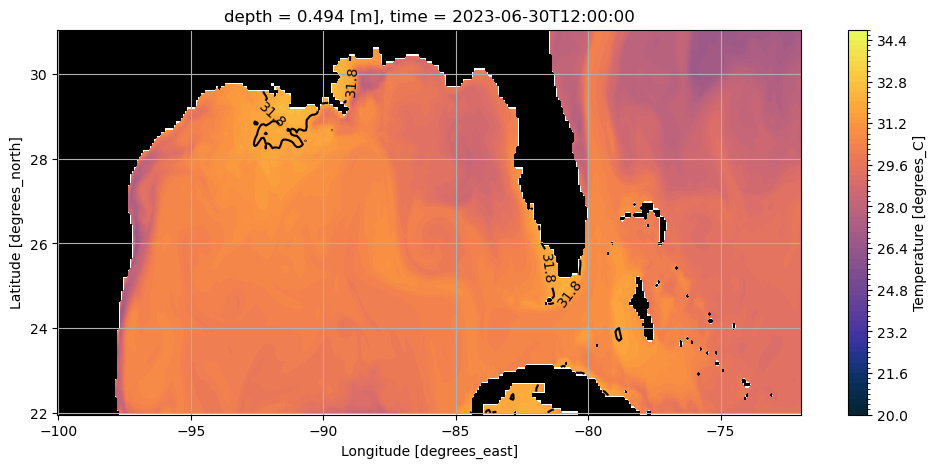

In [101]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap, add_colorbar=False)

gopaf_pottemp.thetao[180,0].plot.contourf(levels=np.arange(20, 35, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = gopaf_pottemp.thetao[180,0].plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid();

### Calculate surface area of 31.8˚C contour

In [102]:
sst_2023_gopaf = gopaf_pottemp.thetao.isel(depth=0).sel(time=slice('2023-01-01', '2023-09-28'))
sst_2023_gopaf

<xarray.DataArray 'thetao' (time: 271, latitude: 109, longitude: 337)>
dask.array<getitem, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

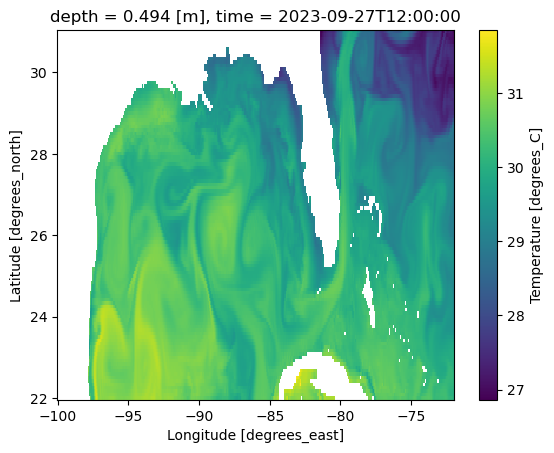

In [103]:
sst_2023_gopaf.sel(time='2023-09-27').plot()

In [176]:
wwm = sst_2023_gopaf.where(sst_2023_gopaf>=31.8)

In [177]:
wwm

<xarray.DataArray 'thetao' (time: 271, latitude: 109, longitude: 337)>
dask.array<where, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

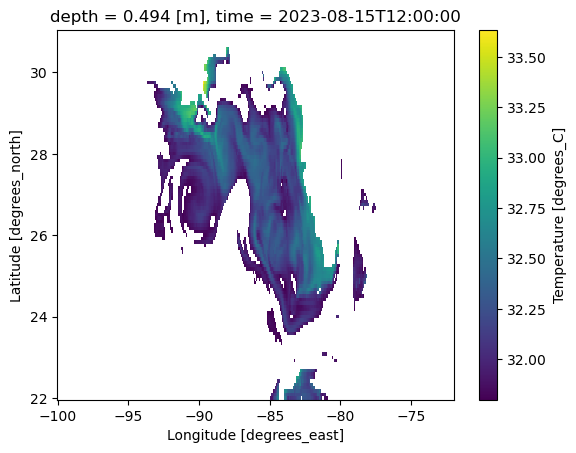

In [178]:
wwm.sel(time='2023-08-15').plot()

In [179]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

area = cell_elements_glorys.dy_l * dx_interp
wwm_area_weighted = wwm * area

In [180]:
wwm_area_weighted

<xarray.DataArray (time: 271, latitude: 109, longitude: 337)>
dask.array<mul, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00

In [109]:
tot_area_2023 = wwm_area_weighted.sum(['latitude', 'longitude', 'time'])

In [110]:
tot_area_2023.compute()

<xarray.DataArray ()>
array(3.355318e+14, dtype=float32)
Coordinates:
    depth    float32 0.494

In [140]:
V.argmax()

<xarray.DataArray ()>
array(226)

In [141]:
V[226]

<xarray.DataArray ()>
array(4.458759e+12, dtype=float32)
Coordinates:
    time     datetime64[ns] 2023-08-15T12:00:00

In [145]:
area.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0

In [147]:
wwm.sel(time='2023-08-15', method='nearest').coords

Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
    time       datetime64[ns] 2023-08-15T12:00:00

In [149]:
max_vol_area = wwm.sel(time='2023-08-15', method='nearest') * area

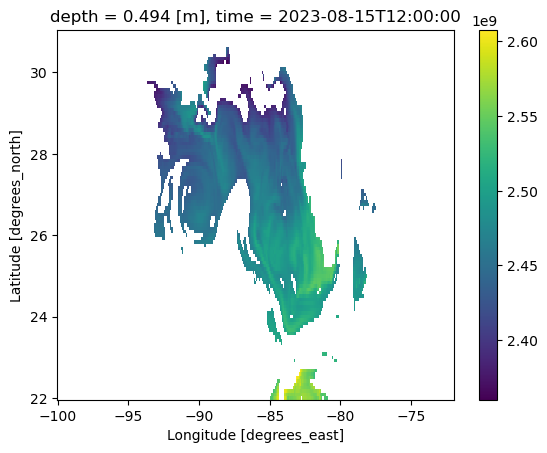

In [151]:
max_vol_area.plot()

In [153]:
max_vol_area.sum(['latitude', 'longitude']).values

array(1.5980365e+13, dtype=float32)

In [182]:
wwm_area_weighted.sum(['latitude', 'longitude']).argmax().values

array(225)

In [184]:
wwm_area_weighted[225].sum(['latitude', 'longitude']).values

array(1.6098694e+13, dtype=float32)

In [186]:
f'{(1.6098694e+13-1.162951e+12):.13}'

'1.4935743e+13'

# Budget

In [36]:
#60s=1min, 60min=1hr, 24hr=1dy, 30.437dys=1mo on avg
60*60*24*30.437 #s

2629756.8000000003

In [80]:
#units: ˚C/s
pt_new = gopaf_pottemp.thetao / (60*60*24) #divide by total sec in a day to get time dim

In [81]:
pt_new

<xarray.DataArray 'thetao' (time: 304, depth: 50, latitude: 109, longitude: 337)>
dask.array<truediv, shape=(304, 50, 109, 337), dtype=float64, chunksize=(1, 50, 109, 337), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [250]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = gopaf_pottemp.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp * dz
masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :]>=31.8) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

In [251]:
V

<xarray.DataArray (time: 304)>
dask.array<truediv, shape=(304,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [252]:
V.load()

<xarray.DataArray (time: 304)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       4.04216742e+12, 3.58660466e+12, 3.26509265e+12, 2.37990602e+12,
       1.18685421e+12, 5.27484060e+11, 4.21409849e+11, 4.68438680e+11,
       4.15441584e+11, 4.55413367e+11, 5.70229522e+11, 7.00542943e+11,
       6.26641076e+11, 2.64732836e+11, 1.50436397e+11, 1.85961742e+11,
       1.20460616e+11, 4.85082778e+09, 1.75864371e+09, 8.79143232e+08,
       4.39551488e+08, 4.39551488e+08, 8.79143232e+08, 3.05011488e+08,
       5.75126208e+08, 5.56785344e+08, 3.24294989e+09, 1.85140797e+10,
       2.91097764e+10, 4.05178409e+10, 6.20992512e+10, 1.16794327e+11,
       1.42144913e+11, 1.58773527e+11, 1.15309011e+11, 9.41187973e+10,
       9.64800348e+10, 8.92238807e+10, 8.18579866e+10, 5.47006956e+10,
       1.01209774e+10, 1.50215501e+09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

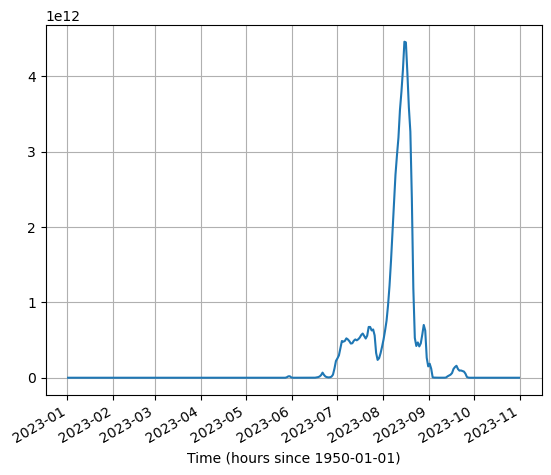

In [253]:
V.plot()
plt.grid()

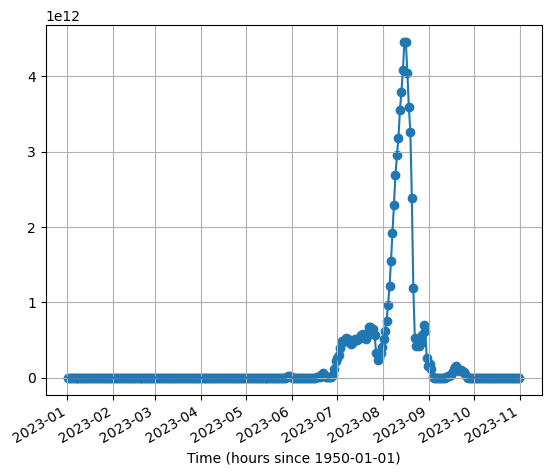

In [254]:
V.plot()
plt.scatter(V.time, V)
plt.grid()

In [255]:
dt_values = (np.diff(V.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], V.time.values[1:])})

In [256]:
V.diff('time', label='upper').time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
Attributes:
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    valid_max:            640668.0
    valid_min:            639924.0

In [257]:
dt.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00

In [258]:
dt[0:3].values

array([86400., 86400., 86400.], dtype=float32)

In [262]:
60*60*24*30.437

2629756.8000000003

In [260]:
dVdt = V.diff('time', label='upper') / dt #m^3/s

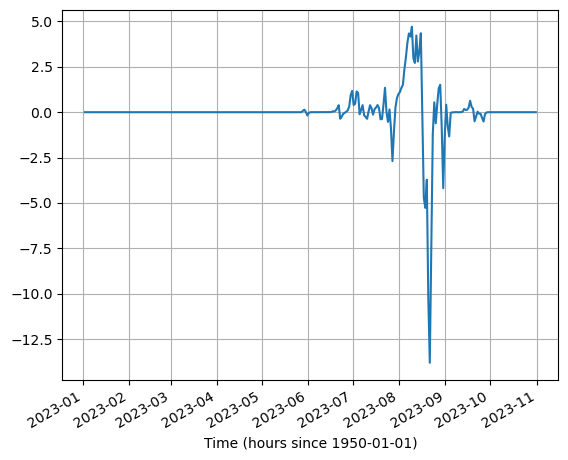

In [261]:
(dVdt/1e6).plot()
plt.grid()

## another way to calculate dVdt (begin)

In [189]:
vol.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03

In [190]:
gopaf_pottemp.thetao.coords

Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [192]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)

tdist = histogram(gopaf_pottemp.thetao[:, 1:, :, :].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth'])

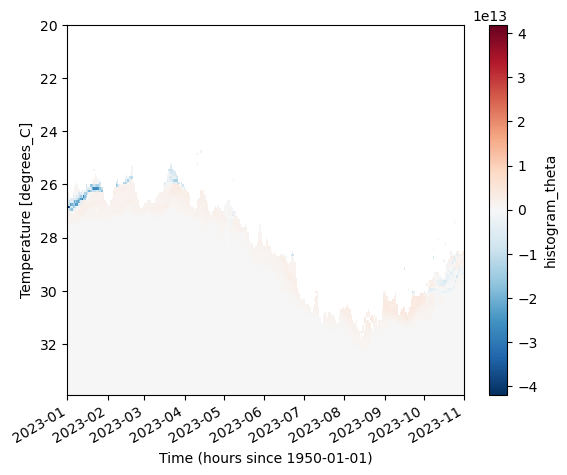

In [196]:
tdist.plot(x='time', yincrease=False)

In [198]:
plt.figure(figsize=(8,3))
(tdist[-1] - tdist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
tdist[0].plot(label='first timestep', color='b')
tdist[-1].plot(label='last timestep', color='r')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

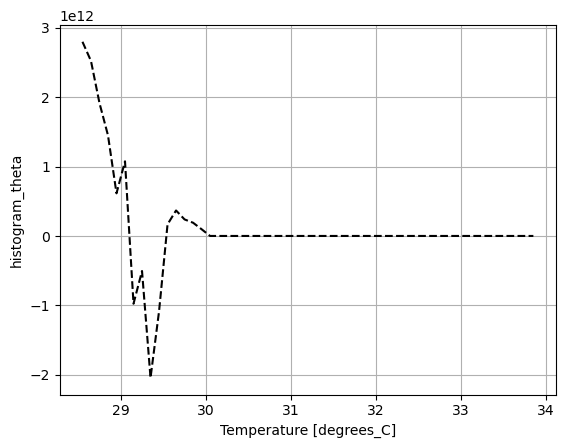

In [200]:
(tdist[-1] - tdist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
plt.grid();

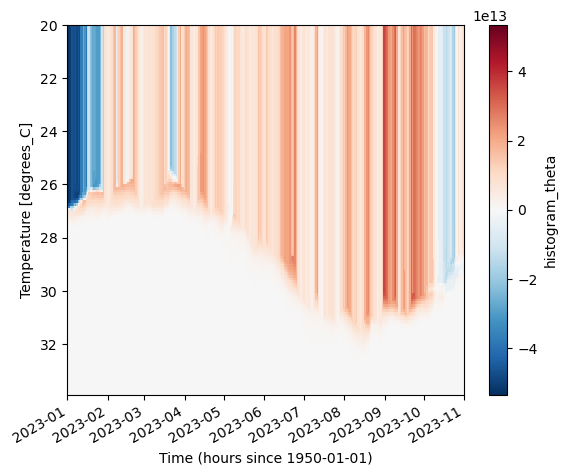

In [204]:
# cumulative volume
V = tdist.isel(theta_bin=slice(None, None, -1)).cumsum(dim='theta_bin')
V.transpose().plot(yincrease=False);

In [209]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.grid();

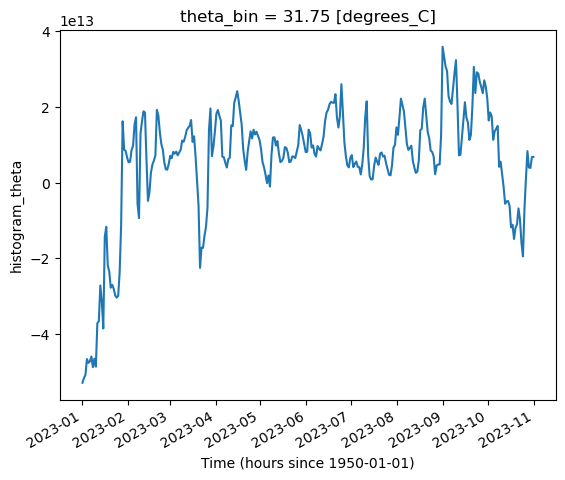

In [218]:
V.sel(theta_bin=31.8, method='nearest').plot()

In [220]:
(np.diff(V.time)/1e9)[0]

numpy.timedelta64(86400,'ns')

In [221]:
delta_V = V.diff(dim='time')
dVdt = delta_V / 86400

In [222]:
dVdt

<xarray.DataArray 'histogram_theta' (time: 303, theta_bin: 139)>
dask.array<truediv, shape=(303, 139), dtype=float64, chunksize=(1, 139), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 20.05 20.15 20.25 20.35 ... 33.65 33.75 33.85

In [223]:
dVdt.sel(theta_bin=31.8, method='nearest').plot()

In [225]:
V32 = tdist.sel(theta_bin=31.8, method='nearest')

In [227]:
V32.plot()

In [230]:
delta_V32 = V32.diff(dim='time')
dVdt32 = delta_V32 / 86400

In [231]:
dVdt32

<xarray.DataArray 'histogram_theta' (time: 303)>
dask.array<truediv, shape=(303,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
    theta_bin  float64 31.75

In [232]:
dVdt32.plot()

## another way to calculate dVdt (end)

In [127]:
one_plt_sliced = one_plt.sel(time=slice('2023-01-02', '2023-10-31'))

In [128]:
one_plt_sliced.to_array().sum('variable')

<xarray.DataArray (time: 303)>
dask.array<sum-aggregate, shape=(303,), dtype=float32, chunksize=(34,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-10-31
    theta_bin  float64 31.75

In [129]:
summed = one_plt_sliced.to_array().sum('variable').load()

In [130]:
summed

<xarray.DataArray (time: 303)>
array([        0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
...
        11620198.   ,   7456576.   ,   6207564.   ,   7194544.   ,
         9046246.   ,   5136674.   ,  -1884285.   ,  -3497033.   ,
          -80856.56 ,    727247.25 ,    980300.25 ,    648636.1  ,
         1350259.4  ,   4926820.5  ,   2838359.5  ,   -257168.14 ,
               0.   ,    428426.88 ,    489075.2  ,   -127425.375,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,    123170.2  ,
               0.   ,    -47214.812,         0.   ,         0.   ,
          310415.2  ,         0.   ,    298811.38 ,    625122.4  ,
          498261.5  ,    188896.94 ,    211289.88 ,         0.   ,
               0.   ,   -183478.56 ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ,         0.   ,
               0.   ,         0.   ,         0.   ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-10-31
    theta_bin  float64 31.75

In [131]:
one_plt_sliced.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T00:00:00.000000000', '2023-01-03T00:00:00.000000000',
       '2023-01-04T00:00:00.000000000', ..., '2023-10-29T00:00:00.000000000',
       '2023-10-30T00:00:00.000000000', '2023-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-10-31
    theta_bin  float64 31.75

In [132]:
dVdt.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
Attributes:
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    valid_max:            640668.0
    valid_min:            639924.0

In [133]:
dVdt_sliced = dVdt.sel(time=slice('2023-01-01', '2023-10-31')).assign_coords({'time':summed.time})

In [233]:
dVdt32_sliced = dVdt32.sel(time=slice('2023-01-01', '2023-10-31')).assign_coords({'time':summed.time})

In [134]:
dVdt_sliced.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T00:00:00.000000000', '2023-01-03T00:00:00.000000000',
       '2023-01-04T00:00:00.000000000', ..., '2023-10-29T00:00:00.000000000',
       '2023-10-30T00:00:00.000000000', '2023-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-10-31
    theta_bin  float64 31.75

In [235]:
(dVdt_sliced/1e6).plot(label='where_dVdt')
(dVdt32_sliced/1e6).plot(label='hist_dVdt')
plt.legend()
plt.grid()

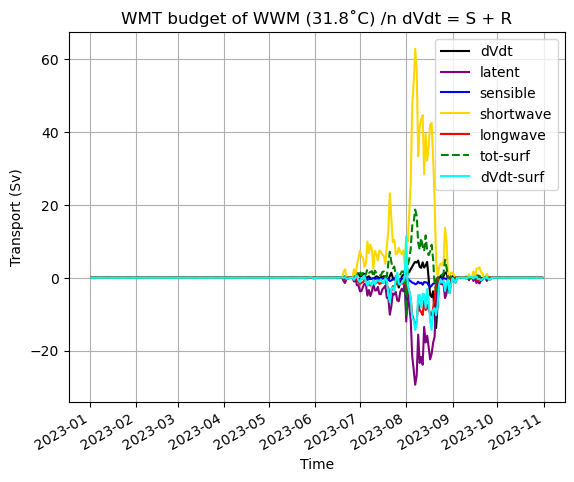

In [135]:
(dVdt_sliced/1e6).plot(label='dVdt', color='k')
(one_plt_sliced.omega_slhf/1e6).plot(label='latent', color='purple')
(one_plt_sliced.omega_sshf/1e6).plot(label='sensible', color='blue')
(one_plt_sliced.omega_ssr/1e6).plot(label='shortwave', color='gold')
(one_plt_sliced.omega_str/1e6).plot(label='longwave', color='r')
(one_plt_sliced/1e6).to_array().sum('variable').plot(label='tot-surf', color='green', linestyle='dashed')
((dVdt_sliced - summed)/1e6).plot(label='dVdt-surf', color='cyan')
plt.grid()
plt.legend()
plt.title('WMT budget of WWM (31.8˚C) /n dVdt = S + R')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time');

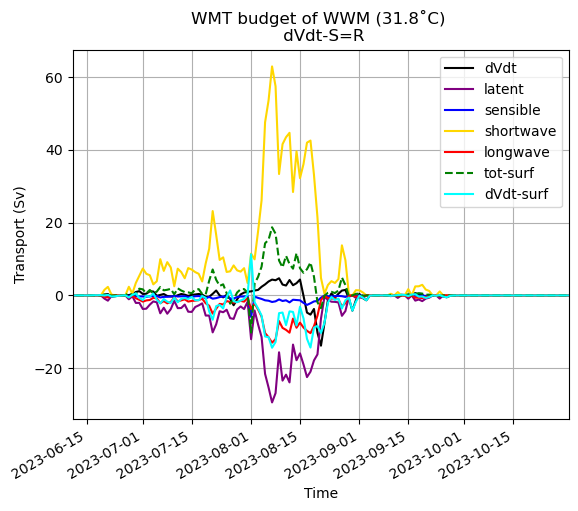

In [136]:
(dVdt_sliced/1e6).plot(label='dVdt', color='k')
(one_plt_sliced.omega_slhf/1e6).plot(label='latent', color='purple')
(one_plt_sliced.omega_sshf/1e6).plot(label='sensible', color='blue')
(one_plt_sliced.omega_ssr/1e6).plot(label='shortwave', color='gold')
(one_plt_sliced.omega_str/1e6).plot(label='longwave', color='r')
(one_plt_sliced/1e6).to_array().sum('variable').plot(label='tot-surf', color='green', linestyle='dashed')
((dVdt_sliced - summed)/1e6).plot(label='dVdt-surf', color='cyan')

plt.grid()
plt.legend()
plt.xlim(summed.time[160], summed.time[-1])
plt.title('WMT budget of WWM (31.8˚C) \n dVdt-S=R')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time');

In [110]:
#uploading histograms
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/dVdt.zarr')
dVdt_sliced.to_zarr(gcsmap_ds, mode='w')